# Summarizing Emails using Machine Learning: Modeling
## Table of Contents
1. Imports & Initalization <br>
2. Retrieve Preprocessed Data <br>
3. TextRank Modeling <br>
    A. Prepare Model <br>
    B. BC3 Corpus Summary <br>
    C. BC3 Corpus ROUGE Evaluation <br>
    D. Enron Dataset Summary <br>

This notebook uses the TextRank algorithim found at:
https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

The algorithim will generate summaries of someone's inbox over a period of time. The BC3 Corpus contains human summaries that can be used to generate ROUGE metrics to better understand the accuracy of the summarizations. 

## Imports & Initalization

In [1]:
import pandas as pd
import numpy as np
import rouge
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter

## Retrieve Preprocessed Data

Load pickled dataframe produced by the Process_Emails notebook. 

In [2]:
#Load Data
ENRON_PICKLE_LOC = "../data/dataframes/wrangled_enron_full_df.pkl"
BC3_PICKLE_LOC  = "../data/dataframes/wrangled_BC3_df.pkl"

enron_df = pd.read_pickle(ENRON_PICKLE_LOC)
BC3_df = pd.read_pickle(BC3_PICKLE_LOC)

## TextRank Modeling

### Prepare Model

This ML algorithim uses the GloVe word embeddings generated by the pre-trained Wikipedia 2014 + Gigaword 5 mode. Below are one time executions to download this model locally.  

In [3]:
#nltk.download('punkt')
#nltk.download('stopwords')
#! wget http://nlp.stanford.edu/data/glove.6B.zip
#! unzip glove*.zip

In [4]:
def extract_word_vectors():
    #This returns word vectors from the pretrained glove model. 
    word_embeddings = {}
    f = open('glove.6B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings

In [5]:
#Extract word vectors. Only need to be done once. 
word_embeddings = extract_word_vectors()

In [6]:
#Retrieve original email sentences and index them. This will be used to generate the extracted summaries. 
def get_extractive_sentences(df):
    if (type(df.extractive_sentences) != list):
        sentences_list = df.extractive_sentences.tolist()
    else:
        sentences_list = df.extractive_sentences
    #flatten list as tuples containting (sentence, dataframe index)  to reassociate summary with original email. 
    sentences = []
    for counter, sublist in enumerate(sentences_list):
        for item in sublist:
            sentences.append([counter, item]) 
    return sentences

In [7]:
#The tokenized sentences were done during preprocessing, 
#so this function retrieves them from the dataframe, then flattens the list. 
def get_tokenized_sentences(df):
    if (type(df.extractive_sentences) != list):
        clean_sentences = df.tokenized_body.tolist()
    else:
        clean_sentences = df.tokenized_body
    #flatten list
    clean_sentences = [y for x in clean_sentences for y in x]
    return clean_sentences

In [8]:
#Create sentence_vectors for each tokenized sentence using the word_embeddings model. 
def create_sentence_vectors(clean_sentences, word_embeddings):
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((300,))
        sentence_vectors.append(v)
    return sentence_vectors

In [9]:
def rank_sentences(sentences, sentence_vectors):
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #Initialize matrix with cosine similarity scores. 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
              sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)
    
    #Pair sentence with it's similarity score then sort.    
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)
    except:
        ranked_sentences = sorted(((0,s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)

    return ranked_sentences

In [10]:
#Function to wrap up summarization process
def summarize_emails(word_embeddings, masked_df):
    if len(masked_df) != 1:
        print("Total number of emails to summarize: " + str(len(masked_df)))
    sentences = get_extractive_sentences(masked_df)
    clean_sentences = get_tokenized_sentences(masked_df)
    #Generate sentence vectors
    sentence_vectors = create_sentence_vectors(clean_sentences, word_embeddings)
    #Create a list of ranked sentences. 
    ranked_sentences = rank_sentences(sentences, sentence_vectors)
    return ranked_sentences

In [11]:
#color scheme to help distinguish summarizaiton text. 
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def display_summary(enron_masked_df, ranked_sentences):
  # Specify number of sentences as a fraction of total emails. 
  sn = (len(enron_masked_df) // 10) + 1

  # Generate summary
  for i in range(sn):
    #pull date and subject from original email
    email_date = str(enron_masked_df['date'].iloc[ranked_sentences[i][1]])
    email_subject = str(enron_masked_df['subject'].iloc[ranked_sentences[i][1]])
    email_from = str(enron_masked_df['from'].iloc[ranked_sentences[i][1]])
    print( bcolors.BOLD + "Date: "+ email_date  + 
          " Subject: " + email_subject +
          " From: " + email_from + bcolors.ENDC +
          "\nSummary: " + str(ranked_sentences[i][2]))

### BC3 Corpus Summary 

In [12]:
#First look into what a single email summary looks like. Pull it from w3c-wai-ig@w3.org since that email has the largest inbox 
masked_df = BC3_df[(BC3_df['to'] == 'w3c-wai-ig@w3.org')][:1]
ranked_sentences = summarize_emails(word_embeddings, masked_df)

In [13]:
#Display full email. 
masked_df['body'].iloc[0]

"I need to help assemble and populate a small computer lab to examine web usability issues. This is a very large ballpark and I need to narrow the options we're going to explore. I'm seeking your opinion about what tools we should test with. We have to start someplace and picking a specific set of tools seems to be a reasonable place. I gather that there's no such thing as a perfect list but I need to put one together anyway. I'd like to hear about your opinions and preferences about tools if you care to share them. I suspect a public forum is not the best place to share these sentiments. Please respond privately so I don't get shot for starting another browser war."

In [14]:
display_summary(masked_df, ranked_sentences)

Date: 1998-11-24 02:06:21+00:00 Subject: Usability testing From: Joe Night <joe.night@gateway2000.com>
Summary: We have to start someplace and picking a specific set of tools seems to be a reasonable place.


In [15]:
#format is: (text rank, email index, summary)
ranked_sentences

[(0.13124809576974086,
  0,
  'We have to start someplace and picking a specific set of tools seems to be a reasonable place.'),
 (0.13124704864637382,
  0,
  "I gather that there's no such thing as a perfect list but I need to put one together anyway."),
 (0.12934673373785552,
  0,
  "I'd like to hear about your opinions and preferences about tools if you care to share them."),
 (0.12512489825792675,
  0,
  "Please respond privately so I don't get shot for starting another browser war."),
 (0.12473648057080033,
  0,
  "This is a very large ballpark and I need to narrow the options we're going to explore."),
 (0.122730609253562,
  0,
  'I need to help assemble and populate a small computer lab to examine web usability issues.'),
 (0.12256419218112273,
  0,
  'I suspect a public forum is not the best place to share these sentiments.'),
 (0.11300194158261798,
  0,
  "I'm seeking your opinion about what tools we should test with.")]

## BC3 Corpus ROUGE Evaluation

The rouge metric (https://pypi.org/project/py-rouge/) is an evaluation metric used to test machine generated summaries against a human "Gold standard". Using the same Text rank summarization methods used on the Enron dataset, the following evaluates the algorithim against the BC3 Corpus. This is one of the few email datasets that contain human summarizations. 

In [16]:
#There are three different human summaries for the same email. 
listno = masked_df['listno'].iloc[0]
email_no = masked_df['email_num'].iloc[0]
masked_summaries = BC3_df[(BC3_df['listno'] == listno) & (BC3_df['email_num'] == email_no)]
masked_summaries.head()

,body,date,email_num,from,listno,subject,to,extractive_sentences,tokenized_body,annotator,summary
356,I need to help assemble and populate a small c...,1998-11-24 02:06:21+00:00,1,Joe Night <joe.night@gateway2000.com>,074-0998972,Usability testing,w3c-wai-ig@w3.org,[I need to help assemble and populate a small ...,[need help assemble populate small computer la...,Annotator5-Part2,Joe says that he is helping to set-up a small ...
357,I need to help assemble and populate a small c...,1998-11-24 02:06:21+00:00,1,Joe Night <joe.night@gateway2000.com>,074-0998972,Usability testing,w3c-wai-ig@w3.org,[I need to help assemble and populate a small ...,[need help assemble populate small computer la...,Annotator3-Part1a,Joe said he needed help assemble and populate ...
358,I need to help assemble and populate a small c...,1998-11-24 02:06:21+00:00,1,Joe Night <joe.night@gateway2000.com>,074-0998972,Usability testing,w3c-wai-ig@w3.org,[I need to help assemble and populate a small ...,[need help assemble populate small computer la...,Annotator1-Part2,A brain storming session requesting help with ...


In [17]:
evaluator = rouge.Rouge(metrics=['rouge-n'],
                           max_n=1,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

full_body = masked_df['body'].iloc[0]
print("Full Email: " + full_body + '\n')

Full Email: I need to help assemble and populate a small computer lab to examine web usability issues. This is a very large ballpark and I need to narrow the options we're going to explore. I'm seeking your opinion about what tools we should test with. We have to start someplace and picking a specific set of tools seems to be a reasonable place. I gather that there's no such thing as a perfect list but I need to put one together anyway. I'd like to hear about your opinions and preferences about tools if you care to share them. I suspect a public forum is not the best place to share these sentiments. Please respond privately so I don't get shot for starting another browser war.



The following shows the R-1 scores. Current benchmarks for text summarization can be found at: https://summari.es/ <br>
Currently, the leading TextRank summary has a R-1 F-Score score of 24.45, while the leading algorithim 'Modified P-G' has a score of 39.91. 

In [18]:
#A perfect summary should give a score of 1.0 
reference = masked_summaries['summary'].iloc[0]
perfect_score = evaluator.get_scores(reference, reference)
print(perfect_score)

{'rouge-1': {'f': 1.0, 'p': 1.0, 'r': 1.0}}


In [19]:
#There is a large amount of variation between the three human summaries. 
references = masked_summaries['summary'].tolist()
hypothesis = ranked_sentences[0][2]
print("ML Summary: " + hypothesis + "\n") 

for reference in references:
    print("Human Summary: " + reference ) 
    scores = evaluator.get_scores(hypothesis, reference)
    print(str(scores) + "\n")

ML Summary: We have to start someplace and picking a specific set of tools seems to be a reasonable place.

Human Summary: Joe says that he is helping to set-up a small computer lab to examine web usability issues and to narrow the options he is asking others' opinions on tools that should be tested.
{'rouge-1': {'f': 0.2692307692307692, 'p': 0.3888888888888889, 'r': 0.20588235294117646}}

Human Summary: Joe said he needed help assemble and populate a computer lab to examine web usability issues, since it's a large topic he wanted to narrow the options explored and hear people's opinion about the tools that should be used. He requested people to share their opinions and preferences privately.
{'rouge-1': {'f': 0.2028985507246377, 'p': 0.3888888888888889, 'r': 0.13725490196078433}}

Human Summary: A brain storming session requesting help with assembling and populating a small computer lab to examine usability issues. Private responses are preferred so as not to start a browser war
{'rou

In [20]:
#Explore rouge scores for the whole dataset. Using textrank on each individual email then compare to corresponding summary.
def sum_single(df):
    scores = []
    for i in range(0, len(df.index)):  
        row = df.iloc[i:i+1, :]
        references = row.summary
        ranked_sentences = summarize_emails(word_embeddings, row)
        hypothesis = ranked_sentences[0][2]
        scores.append(evaluator.get_scores(hypothesis, reference)['rouge-1']['f'])
    return scores

In [21]:
def plot_scores(scores):
    #removing 0 outliers since it meant page rank failed
    scores = [i for i in scores if i != 0.0]
    print("Number of human summaries " + str(len(scores)))
    print('F1 average =  ' + str(sum(scores) / len(scores)))

    _,ax = plt.subplots(figsize = (14,7))
    sns.distplot(scores, bins = 25)
    ax.set_xlabel('ROUGE scores')

Number of human summaries 556
F1 average =  0.0963670711128002


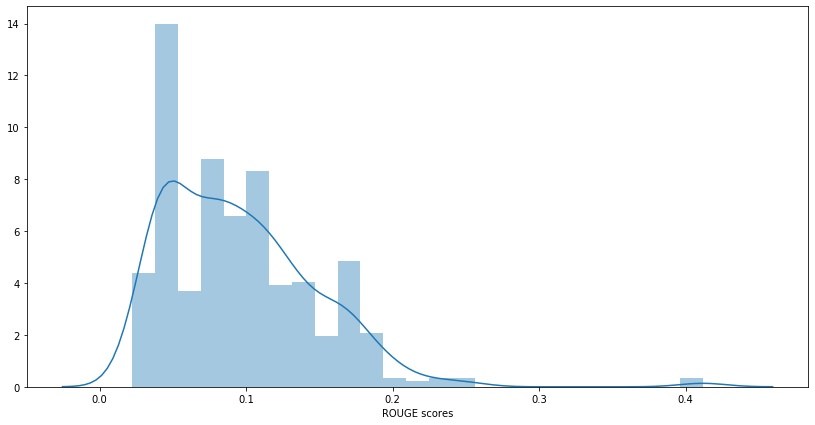

In [22]:
scores = sum_single(BC3_df)
plot_scores(scores)

Number of human summaries 49
F1 average =  0.11331784166159381


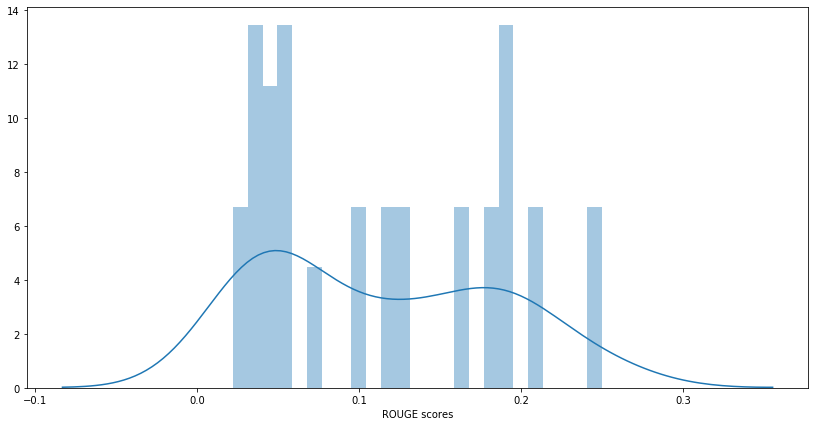

In [23]:
#Take a look at a single inbox. Number of summaries will differ from full inbox, since pagerank fails to converge on certain emails. 
masked_df = BC3_df[BC3_df['to'] == 'w3c-wai-ig@w3.org']
scores = sum_single(masked_df)
plot_scores(scores)

Total number of emails to summarize: 24
Number of human summaries 51
F1 average =  0.2375112191092578


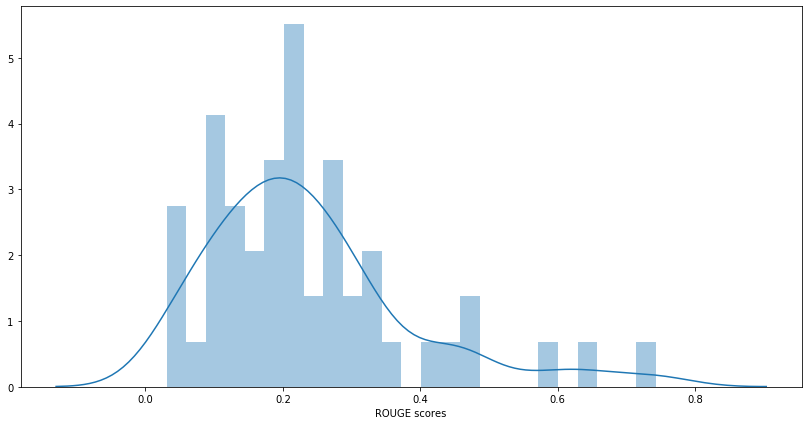

In [24]:
#compare best ML summary with each human summary
def sum_full(df, ranked_sentences):
    scores = []
    for i in range(0, len(df)):
        email_sentences = [item for item in ranked_sentences if i in item]
        hypothesis = max(email_sentences, key=itemgetter(0))
        listno = masked_df['listno'].iloc[i]
        email_num = masked_df['email_num'].iloc[i]
        h_summaries = BC3_df[(BC3_df['listno'] == listno) & (BC3_df['email_num'] == email_num)]['summary']
        for reference in h_summaries:
            scores.append(evaluator.get_scores(hypothesis[2], reference)['rouge-1']['f'])
    return scores

#Try to apply textrank on a full inbox to see if summarization improves with more emails. 
masked_df = masked_df.drop_duplicates(subset='body', keep='first')
ranked_sentences = summarize_emails(word_embeddings, masked_df)
scores = sum_full(masked_df, ranked_sentences)
plot_scores(scores)

We can see a 2x improvement for giving the algorithim the full inbox, rather than trying to summarize each individual email.  

Total number of emails to summarize: 259
Number of human summaries 604
F1 average =  0.22599398085168812


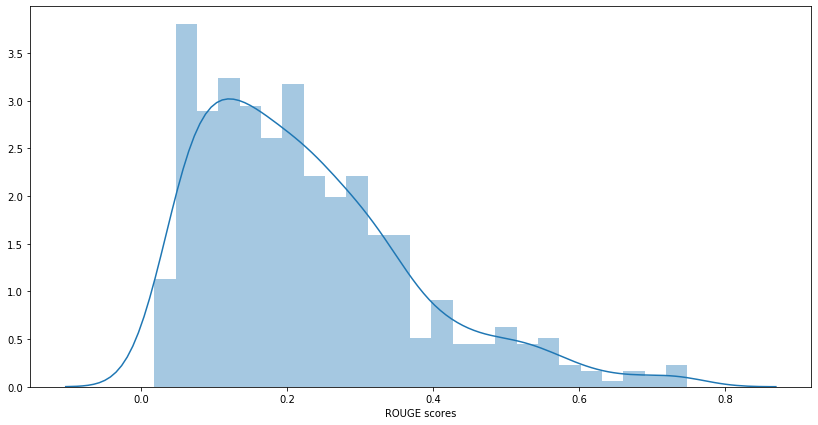

In [25]:
#Try model on full dataset, regardless of person. 
masked_df = BC3_df.drop_duplicates(subset='body', keep='first')
ranked_sentences = summarize_emails(word_embeddings, masked_df)
scores = sum_full(masked_df, ranked_sentences)
plot_scores(scores)

## Enron Dataset Summary 

In [26]:
#Outputs a subset of the enron dataset masked by the person and a timeframe. 
def subset_emails(df, start_date, end_date, person):   
    summarization_mask = (enron_df['date'] >= start_date) & (enron_df['date'] <= end_date) & (enron_df['employee'] == person)
    enron_masked_df = df.loc[summarization_mask]
    return enron_masked_df   

In [27]:
#Define emails to be summarized. 
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'skilling-j'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)

Total number of emails to summarize: 72


In [28]:
display_summary(masked_df, ranked_sentences)

Date: 2001-10-08 08:36:38+00:00 Subject: Update - Basel Conference New York From: news@ibcuk.co.uk
Summary: However, as the business community appears to be trying to get back to normal as far as possible, we have decided that the conference should proceed as planned.
Date: 2001-10-02 19:04:24+00:00 Subject: Jeffrey Skilling, your October E-lert is now available From: mccann@nc.rr.com
Summary: A complete story on the origin of Halloween will be on the Business Cafe Web site October 2531 at http://www.BusinessCafeOnline.com Your October 2001 issue of Elert for personal development in business is now available on http://www.BusinessCafeOnline.com Included in the October 2001 issue are these three articles: Flying Off Over Office Politics What Men Can Learn
Date: 2001-10-04 03:13:05+00:00 Subject: h: Eyeforenergy Briefing From: bruno@eyeforenergy.com
Summary: EDITORIAL A Focus on the latest developments in Europe ARTICLES European Utility Sector: Survival of the Fittest Through Mergers & 

In [30]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

"Dear Mr Skilling, http://www.ibcfinancial.com/bm1272/?source=bm1272em2 Update on IBC's major international conference: BASEL MEETING THE PRACTICAL CHALLENGES 31st October and 1st November 2001 New York We have obviously considered very carefully whether to continue with this event in the light of the recent terrible events in New York. However, as the business community appears to be trying to get back to normal as far as possible, we have decided that the conference should proceed as planned. We therefore hope you will take this excellent opportunity to hear the industry response to the latest Basel proposals on Capital Adequacy and Risk Management, and to gain practical advice on meeting the significant business challenges that these proposals pose to the management of risk within the financial services industry. Conference highlights include: A keynote address from William Rutledge, Executive Vice President, FEDERAL RESERVE BANK OF NEW YORK An impressive panel of leading industry s

In [31]:
#Summarization from another inbox
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'arnold-j'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)
display_summary(masked_df, ranked_sentences)

Total number of emails to summarize: 234


In [32]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

'HOW TO SUBSTANTIALLY INCREASE SALES: MessageId: <200110042136812.SM00207@gmgfbljvm.networksolutions.com> Date: Thu, 4 Oct 2001 21:39:51 0400 Easily accept major credit cards right away! If you would like to speak to someone right now we would be more then happy to answer any questions you might have please provide: Name: Your Phone Number: Best time to call: Merchant Status will help you increase sales by an incredible 50% to 100%. Stop losing valuable sales! With one phone call you can be: Accepting all major credit cards! Accepting checks over the net or by Fax! Accepting real time processing for member sites! Gaining customer loyalty and trust! Close the sale now. No more wondering if "The check is in the mail" We specialize in helping businesses who are just starting out with no credit poor credit or even if you have great credit. Almost everyone is approved! (All information is kept securely and will never be shared with a third party) If you wish to be removed from our mailing l

In [35]:
#One more example
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'lenhart-m'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)
display_summary(masked_df, ranked_sentences)

Total number of emails to summarize: 121
Date: 2001-10-03 20:00:52+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i think i might need to pay up to get a house
Date: 2001-10-05 14:51:13+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i can think of a few things
Date: 2001-10-05 15:30:00+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i will let you know later.
Date: 2001-10-09 19:26:43+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: this is a photo of the girl i think you look like but it isn't really a good pic.
Date: 2001-10-04 16:24:25+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i think i need to pay more than i want to.
Date: 2001-10-10 17:10:04+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i dont think you look like her anymore.
Date: 2001-10-10 17:01:34+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: let me know what she says.
Date: 2001-10-09 20:32:30+00:00 Subject: RE: From: matthew.lenha

In [36]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

'lets bet your dinner on it right now. i think i might need to pay up to get a house'